图像尺寸: (1080, 1920, 3)
相机参数:
焦距: 1761.76
主点: (998.50, 548.84)
基线: 119.36
视差范围: 75 - 358
计算优化视差图中...
计算视差图 - 最小视差: 75, 视差范围: 384


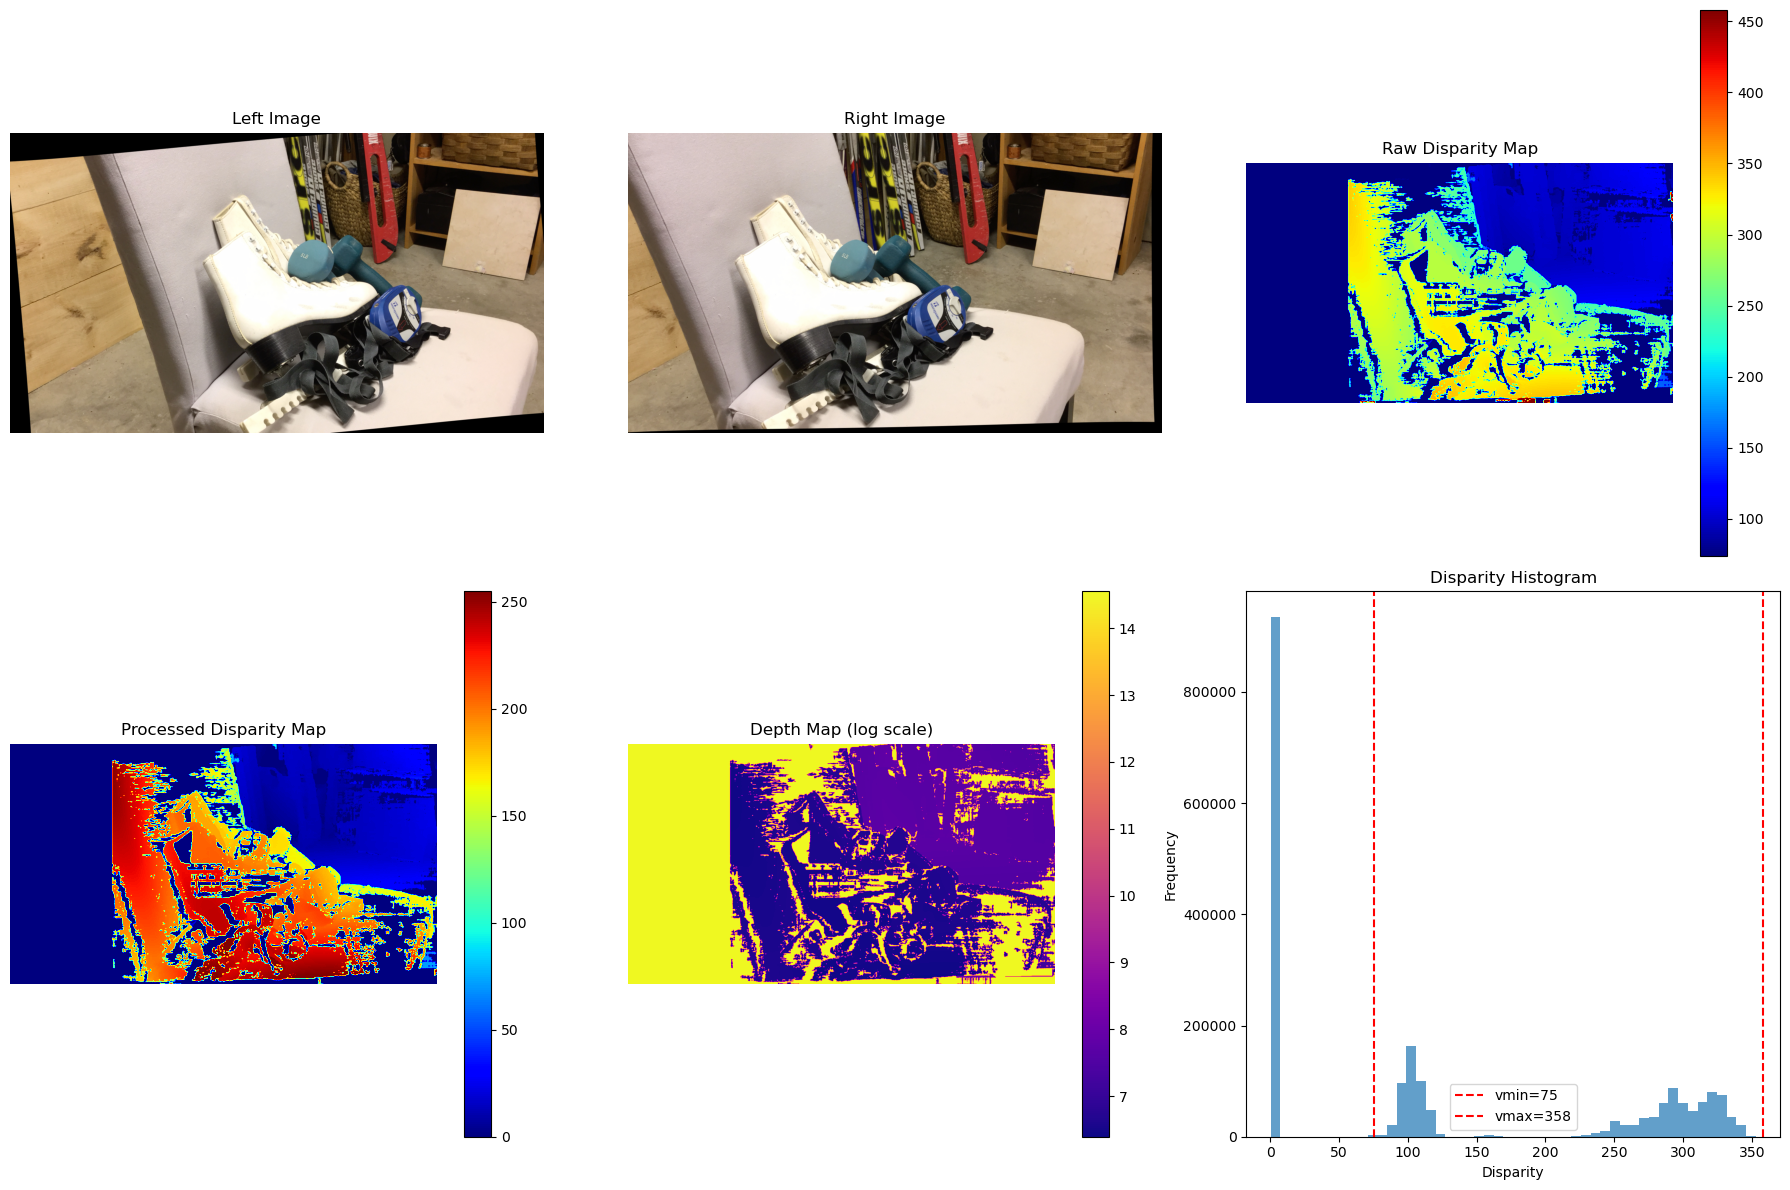


结果统计:
有效视差像素: 2073600/2073600 (100.00%)
视差范围: 0.10 - 352.88
平均视差: 122.64
视差标准差: 132.62
所有结果已保存!


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置字体避免中文警告
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 根据提供的相机参数设置
cam0 = np.array([[1761.76,0,998.50], 
                 [0,1761.76,548.84], 
                 [0, 0, 1]])
cam1 = np.array([[1761.76,0,998.50], 
                 [0,1761.76,548.84], 
                 [0, 0, 1]])
doffs = 0
baseline = 119.36  # 基线距离（毫米）
width = 1920
height = 1080
ndisp = 380        # 视差范围
vmin = 75          # 最小有效视差
vmax = 358         # 最大有效视差

def stereo_disparity_optimized(imgL, imgR):
    """
    使用相机参数优化的视差计算
    
    参数:
        imgL: 左图像
        imgR: 右图像
        
    返回:
        disparity: 视差图
    """
    # 转换为灰度图
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    # 根据相机参数优化SGBM设置
    window_size = 7  # 稍大的窗口以获得更稳定的结果
    
    # 使用提供的视差范围参数
    min_disp = vmin
    num_disp = ndisp
    
    # 确保num_disp是16的倍数
    num_disp = ((num_disp + 15) // 16) * 16
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=5,           # 稍微放宽视差连续性约束
        uniquenessRatio=10,        # 降低唯一性比率以适应更大的视差范围
        speckleWindowSize=200,     # 增加斑点滤波窗口
        speckleRange=3,            # 增加斑点范围
        preFilterCap=63,           # 增加预滤波器容量
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # 计算视差
    print(f"计算视差图 - 最小视差: {min_disp}, 视差范围: {num_disp}")
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    
    return disparity

def convert_disparity_to_depth(disparity, focal_length, baseline):
    """
    将视差图转换为深度图
    
    参数:
        disparity: 视差图
        focal_length: 焦距 (从相机矩阵获取)
        baseline: 基线距离
        
    返回:
        depth: 深度图 (单位: 与baseline相同)
    """
    # 避免除以零
    disparity[disparity <= 0] = 0.1
    
    # 深度 = (焦距 * 基线) / 视差
    depth = (focal_length * baseline) / disparity
    
    return depth

def post_process_disparity(disp, vmin, vmax):
    """
    使用已知的有效视差范围进行后处理
    
    参数:
        disp: 原始视差图
        vmin: 最小有效视差
        vmax: 最大有效视差
        
    返回:
        processed_disp: 处理后的视差图
    """
    # 创建有效视差掩码
    valid_mask = (disp >= vmin) & (disp <= vmax)
    
    # 将无效值设为0
    processed_disp = np.zeros_like(disp)
    processed_disp[valid_mask] = disp[valid_mask]
    
    # 归一化到0-255范围用于显示
    if np.any(valid_mask):
        valid_disp = processed_disp[valid_mask]
        low, high = np.percentile(valid_disp, (1, 99))
        temp_disp = np.clip(processed_disp, low, high)
        processed_disp_vis = np.uint8(255 * (temp_disp - low) / (high - low))
    else:
        processed_disp_vis = np.uint8(255 * (disp - disp.min()) / (disp.max() - disp.min()))
    
    return processed_disp, processed_disp_vis

# 主程序
if __name__ == "__main__":
    # 读取图像
    imgL = cv2.imread("im0.png")  # 替换为你的左图像路径
    imgR = cv2.imread("im1.png")  # 替换为你的右图像路径
    
    
    # 检查图像是否成功加载
    if imgL is None or imgR is None:
        print("错误：无法加载图像，请检查文件路径")
        exit()
    
    print("图像尺寸:", imgL.shape)
    print("相机参数:")
    print(f"焦距: {cam0[0,0]:.2f}")
    print(f"主点: ({cam0[0,2]:.2f}, {cam0[1,2]:.2f})")
    print(f"基线: {baseline}")
    print(f"视差范围: {vmin} - {vmax}")
    
    # 计算视差
    print("计算优化视差图中...")
    raw_disparity = stereo_disparity_optimized(imgL, imgR)
    
    # 后处理
    processed_disparity, disparity_vis = post_process_disparity(raw_disparity, vmin, vmax)
    
    # 转换为深度图
    focal_length = cam0[0, 0]  # 从相机矩阵获取焦距
    depth_map = convert_disparity_to_depth(processed_disparity, focal_length, baseline)
    
    # 显示结果
    plt.figure(figsize=(18, 12))
    
    # 原始图像
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
    plt.title("Left Image")
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
    plt.title("Right Image")
    plt.axis("off")
    
    # 原始视差图
    plt.subplot(2, 3, 3)
    plt.imshow(raw_disparity, cmap="jet")
    plt.title("Raw Disparity Map")
    plt.axis("off")
    plt.colorbar()
    
    # 处理后视差图
    plt.subplot(2, 3, 4)
    plt.imshow(disparity_vis, cmap="jet")
    plt.title("Processed Disparity Map")
    plt.axis("off")
    plt.colorbar()
    
    # 深度图
    plt.subplot(2, 3, 5)
    # 对深度图进行对数变换以便更好地显示
    depth_vis = np.log1p(depth_map)
    depth_vis[depth_map == 0] = 0
    plt.imshow(depth_vis, cmap="plasma")
    plt.title("Depth Map (log scale)")
    plt.axis("off")
    plt.colorbar()
    
    # 视差直方图
    plt.subplot(2, 3, 6)
    valid_disparities = processed_disparity[processed_disparity > 0]
    if len(valid_disparities) > 0:
        plt.hist(valid_disparities.flatten(), bins=50, alpha=0.7)
        plt.axvline(vmin, color='r', linestyle='--', label=f'vmin={vmin}')
        plt.axvline(vmax, color='r', linestyle='--', label=f'vmax={vmax}')
        plt.xlabel("Disparity")
        plt.ylabel("Frequency")
        plt.title("Disparity Histogram")
        plt.legend()
    
    plt.tight_layout()
    plt.savefig("optimized_disparity_result.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # 保存结果
    cv2.imwrite("optimized_disparity.png", disparity_vis)
    cv2.imwrite("depth_map.png", np.uint8(255 * depth_vis / depth_vis.max()))
    
    # 统计信息
    valid_pixels = np.sum(processed_disparity > 0)
    total_pixels = processed_disparity.size
    valid_percentage = (valid_pixels / total_pixels) * 100
    
    print("\n结果统计:")
    print(f"有效视差像素: {valid_pixels}/{total_pixels} ({valid_percentage:.2f}%)")
    print(f"视差范围: {processed_disparity.min():.2f} - {processed_disparity.max():.2f}")
    if len(valid_disparities) > 0:
        print(f"平均视差: {valid_disparities.mean():.2f}")
        print(f"视差标准差: {valid_disparities.std():.2f}")
    
    print("所有结果已保存!")

图像尺寸信息: (1080, 1920, 3)
相机参数配置:
焦距参数: 1761.76
主点坐标: (998.50, 548.84)
基线距离: 119.36
视差范围: 75 - 358
开始计算优化视差图...
正在进行立体匹配计算 - 最小视差: 75, 视差总数: 384


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:188: UserWarning: Glyph 24038 (\N{CJK UNIFIED IDEOGRAPH-5DE6}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  plot_lib.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:188: UserWarning: Glyph 20391 (\N{CJK UNIFIED IDEOGRAPH-4FA7}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  plot_lib.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:188: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  plot_lib.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:188: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  plot_lib.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:188: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missi

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:265: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  result_figure.savefig("stereo_vision_result.png", dpi=300, bbox_inches="tight")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:265: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  result_figure.savefig("stereo_vision_result.png", dpi=300, bbox_inches="tight")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:265: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans.
  result_figure.savefig("stereo_vision_result.png", dpi=300, bbox_inches="tight")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26496\2976747778.py:265: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Arial, DejaVu Sans, DejaVu Sans

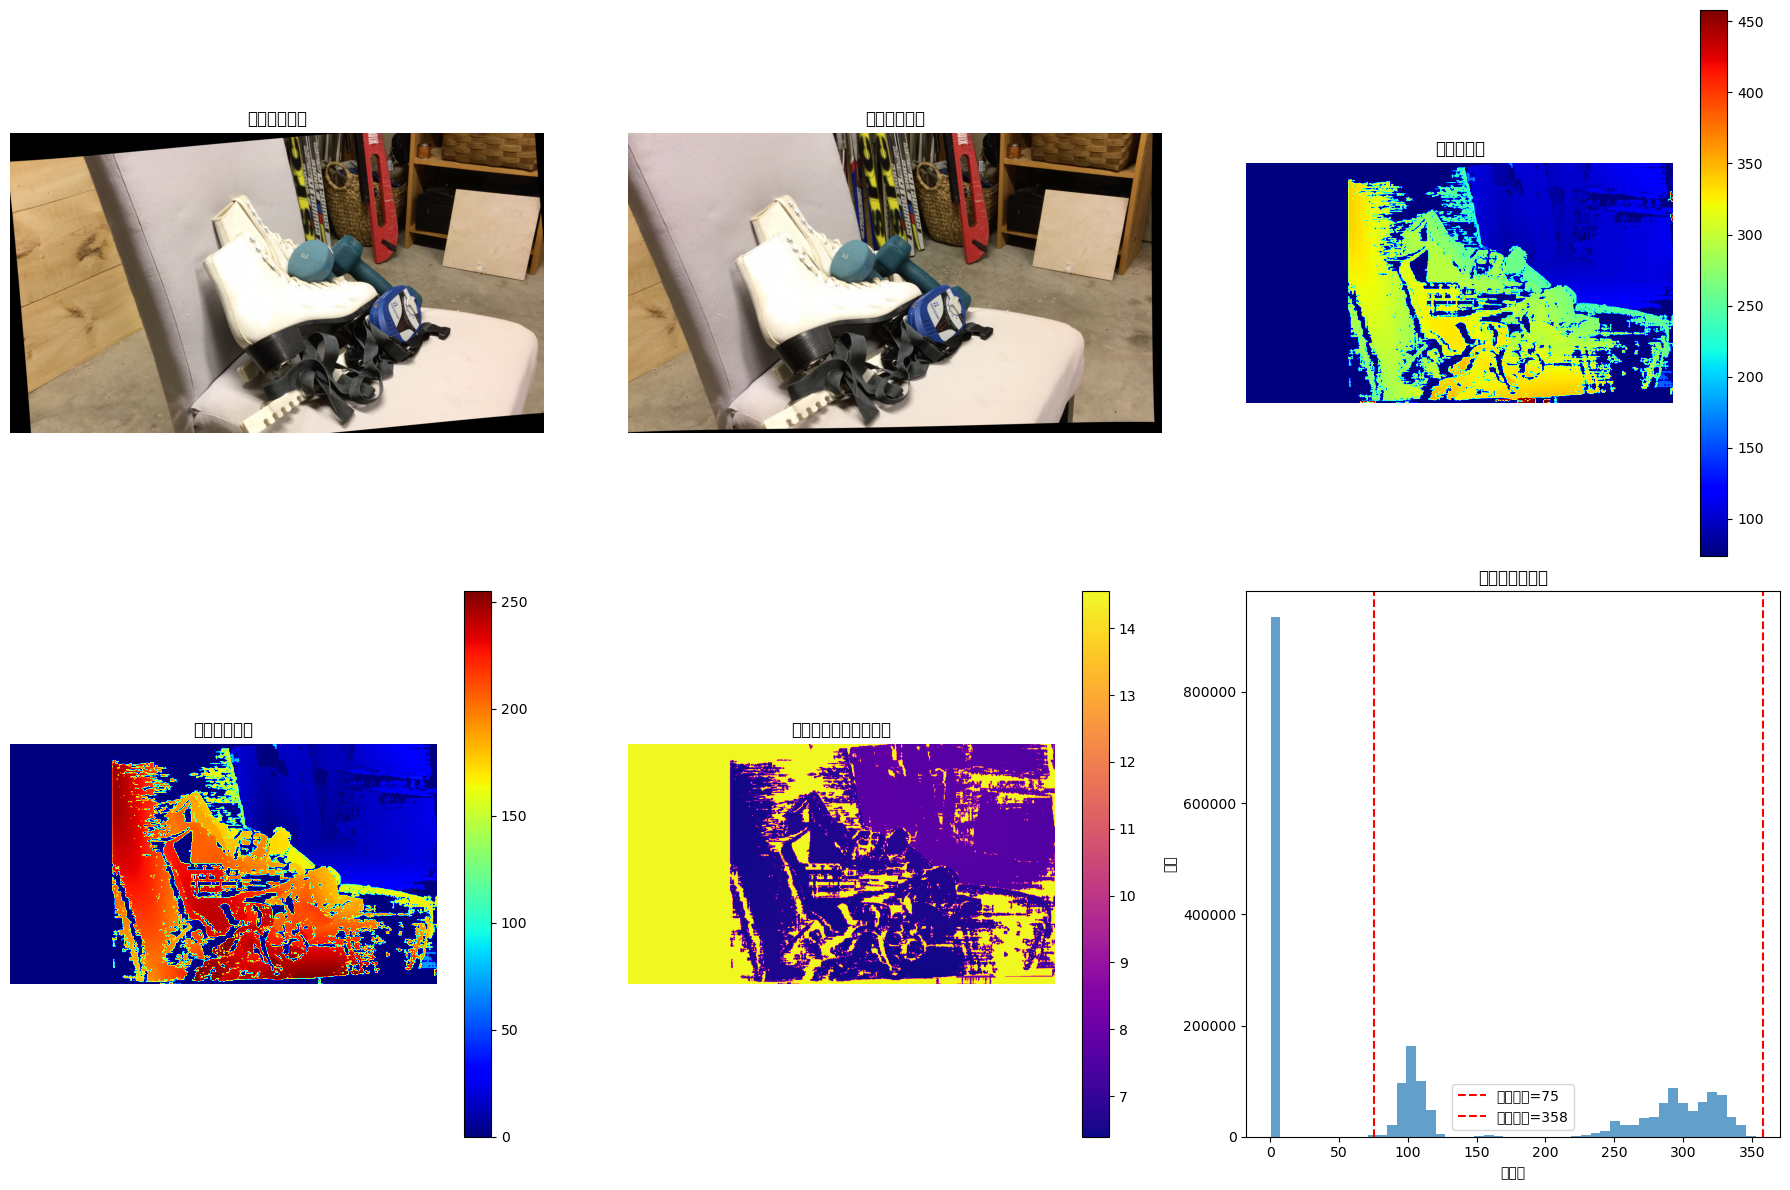


=== 处理结果统计 ===
有效视差像素数量: 2073600/2073600 (100.00%)
视差数值范围: 0.10 - 352.88
平均视差值: 122.64
视差标准差: 132.62
所有处理结果已保存完成!


In [3]:
import cv2 as open_cv
import numpy as np
import matplotlib.pyplot as plot_lib
import os

# 配置绘图参数以兼容中文
plot_lib.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plot_lib.rcParams['axes.unicode_minus'] = False

# 定义相机内部参数矩阵
camera_left = np.array([[1761.76, 0, 998.50], 
                       [0, 1761.76, 548.84], 
                       [0, 0, 1]])
camera_right = np.array([[1761.76, 0, 998.50], 
                        [0, 1761.76, 548.84], 
                        [0, 0, 1]])

# 设置立体视觉系统参数
disparity_offset = 0
stereo_baseline = 119.36  # 双目相机间距（毫米）
image_width = 1920
image_height = 1080
disparity_range = 380     # 视差搜索范围
min_valid_disp = 75       # 最小有效视差阈值
max_valid_disp = 358      # 最大有效视差阈值

def calculate_stereo_disparity(left_img, right_img):
    """
    执行双目立体匹配以生成视差图
    
    输入参数:
        left_img: 左侧相机图像
        right_img: 右侧相机图像
        
    返回结果:
        disparity_map: 计算得到的视差图
    """
    # 将彩色图像转换为灰度图像
    left_gray = open_cv.cvtColor(left_img, open_cv.COLOR_BGR2GRAY)
    right_gray = open_cv.cvtColor(right_img, open_cv.COLOR_BGR2GRAY)
    
    # 配置立体匹配参数
    matching_window = 7
    
    # 设置视差搜索参数
    min_disparity = min_valid_disp
    num_disparities = disparity_range
    
    # 确保视差范围为16的整数倍
    num_disparities = ((num_disparities + 15) // 16) * 16
    
    # 创建SGBM立体匹配器
    stereo_matcher = open_cv.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=matching_window,
        P1=8 * 3 * matching_window ** 2,
        P2=32 * 3 * matching_window ** 2,
        disp12MaxDiff=5,
        uniquenessRatio=10,
        speckleWindowSize=200,
        speckleRange=3,
        preFilterCap=63,
        mode=open_cv.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # 执行立体匹配计算
    print(f"正在进行立体匹配计算 - 最小视差: {min_disparity}, 视差总数: {num_disparities}")
    raw_disparity = stereo_matcher.compute(left_gray, right_gray)
    normalized_disparity = raw_disparity.astype(np.float32) / 16.0
    
    return normalized_disparity

def transform_disparity_to_depth(disparity_data, focal_len, base_distance):
    """
    将视差数据转换为深度信息
    
    输入参数:
        disparity_data: 视差图数据
        focal_len: 相机焦距参数
        base_distance: 双目基线距离
        
    返回结果:
        depth_data: 深度图数据
    """
    # 处理零视差情况以避免除零错误
    disparity_data[disparity_data <= 0] = 0.1
    
    # 应用深度转换公式：深度 = (焦距 × 基线) / 视差
    depth_data = (focal_len * base_distance) / disparity_data
    
    return depth_data

def refine_disparity_map(input_disparity, disp_min, disp_max):
    """
    对视差图进行后处理优化
    
    输入参数:
        input_disparity: 原始视差图
        disp_min: 最小允许视差值
        disp_max: 最大允许视差值
        
    返回结果:
        refined_disp: 优化后的视差图
        visual_disp: 用于可视化的视差图
    """
    # 创建有效视差区域掩码
    valid_disp_mask = (input_disparity >= disp_min) & (input_disparity <= disp_max)
    
    # 初始化处理后的视差图
    refined_disp = np.zeros_like(input_disparity)
    refined_disp[valid_disp_mask] = input_disparity[valid_disp_mask]
    
    # 准备用于显示的视差图
    if np.any(valid_disp_mask):
        valid_values = refined_disp[valid_disp_mask]
        low_percentile, high_percentile = np.percentile(valid_values, (1, 99))
        temp_disp = np.clip(refined_disp, low_percentile, high_percentile)
        visual_disp = np.uint8(255 * (temp_disp - low_percentile) / (high_percentile - low_percentile))
    else:
        min_val = input_disparity.min()
        max_val = input_disparity.max()
        if max_val > min_val:
            visual_disp = np.uint8(255 * (input_disparity - min_val) / (max_val - min_val))
        else:
            visual_disp = np.zeros_like(input_disparity, dtype=np.uint8)
    
    return refined_disp, visual_disp

def visualize_results(left_img, right_img, raw_disp, proc_disp_vis, depth_vis, hist_data):
    """
    创建结果可视化图表
    
    输入参数:
        left_img: 左相机图像
        right_img: 右相机图像  
        raw_disp: 原始视差图
        proc_disp_vis: 处理后视差图
        depth_vis: 深度可视化图
        hist_data: 直方图数据
    """
    fig = plot_lib.figure(figsize=(18, 12))
    
    # 显示左相机图像
    fig.add_subplot(2, 3, 1)
    plot_lib.imshow(open_cv.cvtColor(left_img, open_cv.COLOR_BGR2RGB))
    plot_lib.title("左侧相机图像")
    plot_lib.axis("off")
    
    # 显示右相机图像
    fig.add_subplot(2, 3, 2)
    plot_lib.imshow(open_cv.cvtColor(right_img, open_cv.COLOR_BGR2RGB))
    plot_lib.title("右侧相机图像")
    plot_lib.axis("off")
    
    # 显示原始视差图
    fig.add_subplot(2, 3, 3)
    plot_lib.imshow(raw_disp, cmap="jet")
    plot_lib.title("原始视差图")
    plot_lib.axis("off")
    plot_lib.colorbar()
    
    # 显示处理后视差图
    fig.add_subplot(2, 3, 4)
    plot_lib.imshow(proc_disp_vis, cmap="jet")
    plot_lib.title("优化后视差图")
    plot_lib.axis("off")
    plot_lib.colorbar()
    
    # 显示深度图
    fig.add_subplot(2, 3, 5)
    plot_lib.imshow(depth_vis, cmap="plasma")
    plot_lib.title("深度图（对数坐标系）")
    plot_lib.axis("off")
    plot_lib.colorbar()
    
    # 显示视差分布直方图
    fig.add_subplot(2, 3, 6)
    if len(hist_data) > 0:
        plot_lib.hist(hist_data.flatten(), bins=50, alpha=0.7)
        plot_lib.axvline(min_valid_disp, color='r', linestyle='--', label=f'最小视差={min_valid_disp}')
        plot_lib.axvline(max_valid_disp, color='r', linestyle='--', label=f'最大视差={max_valid_disp}')
        plot_lib.xlabel("视差值")
        plot_lib.ylabel("频数")
        plot_lib.title("视差分布直方图")
        plot_lib.legend()
    
    plot_lib.tight_layout()
    return fig

def analyze_results(processed_disparity):
    """
    分析并输出处理结果统计信息
    
    输入参数:
        processed_disparity: 处理后的视差图
        
    返回结果:
        valid_pixels: 有效像素数量
        valid_percentage: 有效像素百分比
        valid_disparities: 有效视差值数组
    """
    valid_pixels = np.sum(processed_disparity > 0)
    total_pixels = processed_disparity.size
    valid_percentage = (valid_pixels / total_pixels) * 100
    
    valid_disparities = processed_disparity[processed_disparity > 0]
    
    print("\n=== 处理结果统计 ===")
    print(f"有效视差像素数量: {valid_pixels}/{total_pixels} ({valid_percentage:.2f}%)")
    print(f"视差数值范围: {processed_disparity.min():.2f} - {processed_disparity.max():.2f}")
    
    if len(valid_disparities) > 0:
        print(f"平均视差值: {valid_disparities.mean():.2f}")
        print(f"视差标准差: {valid_disparities.std():.2f}")
    
    return valid_pixels, valid_percentage, valid_disparities

# 程序主入口
if __name__ == "__main__":
    # 读取双目图像数据
    left_image = open_cv.imread("im0.png")
    right_image = open_cv.imread("im1.png")
    
    # 验证图像加载状态
    if left_image is None or right_image is None:
        print("错误：图像文件加载失败，请检查文件路径是否正确")
        exit()
    
    print("图像尺寸信息:", left_image.shape)
    print("相机参数配置:")
    print(f"焦距参数: {camera_left[0,0]:.2f}")
    print(f"主点坐标: ({camera_left[0,2]:.2f}, {camera_left[1,2]:.2f})")
    print(f"基线距离: {stereo_baseline}")
    print(f"视差范围: {min_valid_disp} - {max_valid_disp}")
    
    # 执行立体匹配计算
    print("开始计算优化视差图...")
    disparity_result = calculate_stereo_disparity(left_image, right_image)
    
    # 对视差图进行后处理
    final_disparity, disparity_visualization = refine_disparity_map(
        disparity_result, min_valid_disp, max_valid_disp)
    
    # 计算深度图
    focal_length_value = camera_left[0, 0]
    depth_result = transform_disparity_to_depth(
        final_disparity, focal_length_value, stereo_baseline)
    
    # 准备深度可视化数据
    depth_visualization = np.log1p(depth_result)
    depth_visualization[depth_result == 0] = 0
    
    # 准备直方图数据
    valid_disp_values = final_disparity[final_disparity > 0]
    
    # 生成可视化图表
    result_figure = visualize_results(
        left_image, right_image, 
        disparity_result, disparity_visualization,
        depth_visualization, valid_disp_values
    )
    
    # 保存结果图表
    result_figure.savefig("stereo_vision_result.png", dpi=300, bbox_inches="tight")
    plot_lib.show()
    
    # 保存处理结果图像
    open_cv.imwrite("final_disparity_map.png", disparity_visualization)
    
    depth_normalized = np.uint8(255 * depth_visualization / depth_visualization.max())
    open_cv.imwrite("final_depth_map.png", depth_normalized)
    
    # 输出统计信息
    valid_count, valid_ratio, disp_values = analyze_results(final_disparity)
    
    print("所有处理结果已保存完成!")